In [1]:
# Imports
import os
import sys
import pandas as pd
import textstat
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
from collections import Counter

In [2]:
def load_data():
    # Define path
    #os.chdir('../../data')
    
    # Read datasets
    submissions = pd.read_csv("submissions.csv", sep = ';')
    movie_titles = pd.read_csv("movie_titles.csv", sep = ';')
    comments = pd.read_csv("comments.csv", sep = ';')
    submissions = submissions.fillna("")
    
    return submissions, movie_titles, comments

In [3]:
def movie_title_sep(movie_titles):
    """
    The movie_titles dataset contains the movies with their release years in a same string, 
    we might need them apart
    """
    movie_titles['title'] = movie_titles['movie_title'].str[:-6]
    movie_titles['year'] = movie_titles['movie_title'].str[-5:-1]
    
    return movie_titles

 # Explore submission texts and titles

In [4]:
def text_stats_and_readability_scores(text):
    # Check the readability of the submissions
    # More readability scores availble at: https://pypi.org/project/textstat/
    
    textstat.set_lang('en')
    syllable_count = textstat.syllable_count(text)
    number_of_words = textstat.lexicon_count(text, removepunct=True)
    number_of_sentences = textstat.sentence_count(text)
    
    flesch_score = textstat.flesch_reading_ease(text)
    flesch_kincaid = textstat.flesch_kincaid_grade(text)
    automated_readability_index = textstat.automated_readability_index(text)
    
    return number_of_words, number_of_sentences, flesch_score, flesch_kincaid, automated_readability_index

In [5]:
def text_stats_readabilities(submissions):
    
    all_stats = pd.DataFrame()

    for index, row in submissions.iterrows():
        number_of_words, number_of_sentences, flesch_score, flesch_kincaid, automated_readability_index = text_stats_and_readability_scores(row['reddit_submission_title'] + row['reddit_submission_text'])  
        all_stats = all_stats.append([[row['reddit_submission_id'], number_of_words, number_of_sentences, flesch_score, flesch_kincaid, automated_readability_index]])
        
    all_stats.columns = ["ID", "# Words", "# Sentences", "Flesch score", "Flesch-Kincaid", "Automated Rdb. Index"]
    
    print("Average number of words: ", np.mean(all_stats["# Words"]))
    print("Average number of sentences: ", np.mean(all_stats["# Sentences"]))
    print("Average Flesch Reading Ease score: ", np.mean(all_stats["Flesch score"]))
    print("Average Flesch-Kincaid score: ", np.mean(all_stats["Flesch-Kincaid"]))
    print("Average Automated readability index: ", np.mean(all_stats["Automated Rdb. Index"]))
    
    return all_stats

In [6]:
def plot_histogram(data, title, x):
    #plt.figure()
    #sns.set(style="darkgrid")
    #fig, axs = plt.subplots(2, figsize=(8,8))
    #fig.tight_layout(h_pad=4)
    #axs[0,].hist(stats["# Sentences"])
    #axs[0,].set_title('Sentences per submission')
    #axs[0,].set(xlabel='Number of sentences', ylabel='Count')
    #axs[1,].hist(stats["# Words"])
    #axs[1,].set_title('Words per submission')
    #axs[1,].set(xlabel='Number of words', ylabel='Count')

    #fig.suptitle('Distribution of submissions length in terms of sentences and words', fontsize=14)
    #plt.subplots_adjust(top=0.9)
    
    sns.set(style="darkgrid")
    plt.hist(data, bins=60)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel('Frequency')

In [7]:
def plot_histogram_4(entities_cnt, title):
    sns.set(style="darkgrid")
    
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    fig.tight_layout(h_pad=4)
    axs[0, 0].hist([entities_cnt['# pos keywords'], entities_cnt['# neg keywords']], bins=6, label=['positive keywords', 'negative keywords'])
    axs[0, 0].set_title('Keywords')
    axs[0, 0].set(xlabel='Mentions per submission', ylabel='Count of occurences')
    axs[0, 0].legend()
    
    axs[0, 1].hist([entities_cnt['# pos genres'], entities_cnt['# neg_genres']], bins=7, label=['positive genres', 'negative genres'])
    axs[0, 1].set_title('Genres')
    axs[0, 1].set(xlabel='Mentions per submission')
    axs[0, 1].legend()
    
    axs[1, 0].hist([entities_cnt['# pos actors'], entities_cnt['# neg actors']], bins=6, label=['positive actors', 'negative actors'])
    axs[1, 0].set_title('Actors')
    axs[1, 0].set(xlabel='Mentions per submission', ylabel='Count of occurences')
    axs[1, 0].legend()
    
    axs[1, 1].hist([entities_cnt['# pos movies'], entities_cnt['# neg movies']], bins=4, label=['positive movies', 'negative movies'])
    axs[1, 1].set_title('Movies')
    axs[1, 1].set(xlabel='Mentions per submission')
    axs[1, 1].legend()
    
    fig.suptitle('Entity mention frequency in submissions', fontsize=14)
    plt.subplots_adjust(top=0.9)

In [8]:
#Plot a histogram of the movie title lengths in words so that we can know in what range we expect our movie names
def plot_movie_titles(movie_titles):
    title_lengths = []
    for line in movie_titles:
        splits = line.split(' ')
        splits = splits[:-1]
        title_lengths.append(len(splits))
    plt.figure()
    plt.title('Length of movie titles')
    plt.hist(title_lengths)
    plt.show()
    plt.savefig('movie_titles_length.png')

In [9]:
def plot_submissions_length(submissions):
    lengths = []
    for submission in submissions:
        splits = submission.split(' ')
        splits = splits[:-1]
        lengths.append(len(splits))
    plt.figure()
    plt.title('Length of submissions')
    plt.hist(lengths)
    plt.show()
    plt.savefig('submissions_length.png')

In [10]:
def count_entities(submissions):
    entities_stat = pd.DataFrame()
    for index, row in submissions.iterrows():
        pos_actors_mention = 0
        neg_actors_mention = 0
        pos_genres_mention = 0
        neg_genres_mention = 0
        pos_movies_mention = 0
        neg_movies_mention = 0
        pos_keywords_mention = 0
        neg_keywords_mention = 0
        if(len(row['positive_actors']) < 1):
            pos_actors_mention = 0
        else:
            splits_actor_pos = row['positive_actors'].split("|")
            pos_actors_mention = len(splits_actor_pos)
        if(len(row['negative_actors']) < 1):
            neg_actors_mention = 0
        else:
            splits_actor_neg = row['negative_actors'].split("|")
            neg_actors_mention = len(splits_actor_neg)
        
        if(len(row['positive_genres']) < 1):
            pos_genres_mention = 0
        else:
            splits_genre_pos = row['positive_genres'].split("|")
            pos_genres_mention = len(splits_genre_pos)
        if(len(row['negative_genres']) < 1):
            neg_genres_mention = 0
        else:
            splits_genre_neg = row['negative_genres'].split("|")
            neg_genres_mention = len(splits_genre_neg)
        
        splits_movie_pos = row['positive_movie_ids'].split("|")
        pos_movies_mention = len(splits_movie_pos)
        splits_movie_neg = row['negative_movie_ids'].split("|")
        neg_movies_mention = len(splits_movie_neg)
        
        splits_keywords_pos = row['positive_keywords'].split("|")
        pos_keywords_mention = len(splits_keywords_pos)
        splits_keywords_neg = row['negative_keywords'].split("|")
        neg_keywords_mention = len(splits_keywords_neg)
        
        entities_stat = entities_stat.append([[row['reddit_submission_id'], pos_actors_mention, neg_actors_mention, 
                                               pos_actors_mention + neg_actors_mention, pos_genres_mention, 
                                               neg_genres_mention, pos_genres_mention + neg_genres_mention, 
                                               pos_movies_mention, neg_movies_mention, pos_movies_mention + neg_movies_mention, 
                                               pos_keywords_mention, neg_keywords_mention, pos_keywords_mention + neg_keywords_mention]])
        
    entities_stat.columns = ["ID", "# pos actors", "# neg actors", "# actors", "# pos genres", "# neg_genres", "# genres",
                            "# pos movies", "# neg movies", "# movies", "# pos keywords", "# neg keywords", "# keywords"]
    
    print("Average number of movies per submission: ", np.mean(entities_stat["# movies"]))
    print("Average number of actors per submission: ", np.mean(entities_stat["# actors"]))
    print("Average number of genres per submission: ", np.mean(entities_stat["# genres"]))
    print("Average number of keywords per submission: ", np.mean(entities_stat["# keywords"]))
    
    return entities_stat

Average number of words:  58.913513513513514
Average number of sentences:  4.017567567567568
Average Flesch Reading Ease score:  71.54447297297305
Average Flesch-Kincaid score:  7.191351351351353
Average Automated readability index:  12.694391891891888


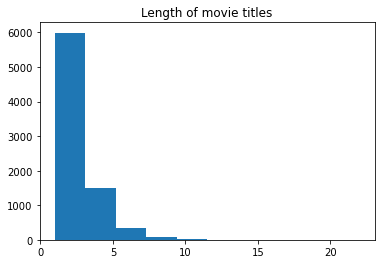

Average number of movies per submission:  4.67972972972973
Average number of actors per submission:  0.06959459459459459
Average number of genres per submission:  0.47297297297297297
Average number of keywords per submission:  4.125


<Figure size 432x288 with 0 Axes>

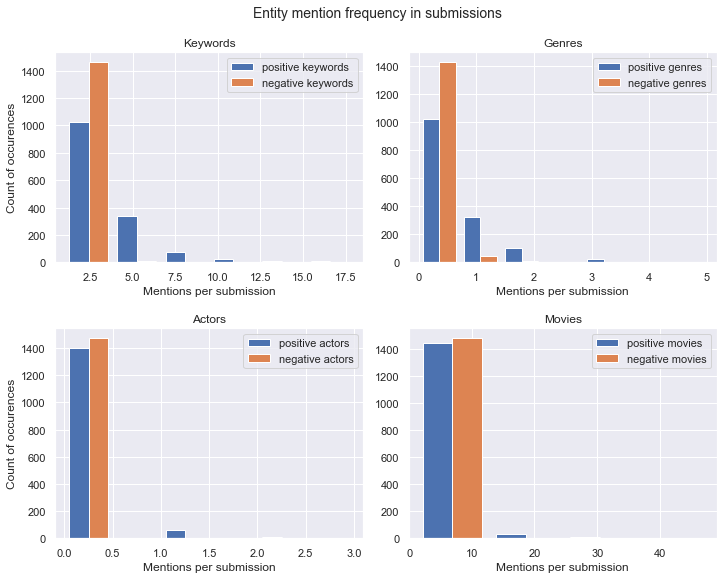

In [12]:
os.chdir('../../data')

# Load datasets
submissions, movie_titles, comments = load_data()

# Preview submission
submissions.head()

# Add separate columns for the title of the movie and the year
movie_titles = movie_title_sep(movie_titles)

# Preview movie titles
movie_titles.head()

# Perform readability statistics over the submissions
stats = text_stats_readabilities(submissions)

# Save readability stats
stats.to_csv("readability_statistics_submissions.csv", index = False)

#plot_histogram(stats["Flesch score"], 'Flesch score', 'Readability score')
#plot_histogram(stats["Flesch-Kincaid"], 'Flesch-Kincaid score', 'Readability score')
#plot_histogram(stats["Automated Rdb. Index"], 'Automated Readability Index', 'Readability index')
#plot_histogram(stats["# Sentences"], 'Number of sentences per submission', 'Num. of sentences')

plot_movie_titles(movie_titles['title'])

# Calculate entity-mention statistics per submission
entities_cnt = count_entities(submissions)

# Save entity stats
entities_cnt.to_csv("entities_cnt.csv", index = False)
plot_histogram_4(entities_cnt, "Entity mention frequency in submissions")